# 1D ResNet based EEGNet Starter usingonly  RAW EEG Features!

This is the training notebook for 1D based solution in Kaggle's Brain comp. It scores 0.722 on GroupKfold 5 Folds split. 5 Fold submission barely took around 2 minutes to run & achieved 0.48 lb score.

This model only uses only 8 channels from raw EEG signals as shared by [Chris Deotte](http://https://www.kaggle.com/code/cdeotte/wavenet-starter-lb-0-52?scriptVersionId=160158478) 

#### Note: To run this notebook on Kaggle, you need to change couple of paths. I ran the notebook on my local system. Kindly reach out in comments if you are stuck somewhere.

![img1](https://github.com/Nischaydnk/hms-brain-prediction/blob/13e2fd30726f63484ea917ccf8621310f8a09be7/Screenshot%202024-01-29%20at%209.49.13%20AM.png)
![img2](https://github.com/Nischaydnk/hms-brain-prediction/blob/13e2fd30726f63484ea917ccf8621310f8a09be7/Screenshot%202024-01-29%20at%209.50.30%20AM.png)

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn import model_selection
import torchvision.transforms as transforms
import torchvision.io 
import librosa
from PIL import Image
import albumentations as alb
import torch.multiprocessing as mp
import warnings
import os

warnings.filterwarnings('ignore')

from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, EarlyStopping


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Config Class

In [2]:
class Config:

    use_aug = False
    num_classes = 6
    batch_size = 32
    epochs = 25
    PRECISION = 16    
    PATIENCE = 20    
    seed = 2024
    pretrained = False            
    weight_decay = 1e-2
    use_mixup = False
    mixup_alpha = 0.1   
    num_channels = 8
    data_root = "/kaggle/input/hms-harmful-brain-activity-classification/"
    raw_eeg_path = "/kaggle/input/brain-eegs/eegs.npy"
    
    LR = 8e-3
    processed_train = None
    output_dir = '/kaggle/working'
    trn_folds = [0,1,2,3,4]
    
    

In [3]:
if not os.path.exists(Config.output_dir):
    os.makedirs(Config.output_dir)

In [4]:
pl.seed_everything(Config.seed, workers=True)

2024

In [5]:
def config_to_dict(cfg):
    return dict((name, getattr(cfg, name)) for name in dir(cfg) if not name.startswith('__'))

In [6]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt

df = pd.read_csv(f'{Config.data_root}train.csv')
print( df.shape )


(106800, 15)


## Parquet to EEG Signals Numpy Processing

In [7]:

EEG_IDS = df.eeg_id.unique()

TARGETS = df.columns[-6:]
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS_INV = {x:y for y,x in TARS.items()}

train = df.groupby('eeg_id')[['patient_id']].agg('first')

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
train = train.loc[train.eeg_id.isin(EEG_IDS)]
print('Train Data with unique eeg_id shape:', train.shape )


Train Data with unique eeg_id shape: (17089, 9)


In [8]:
train.head()

,eeg_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [9]:
Config.num_classes = len(TARS.keys())

In [10]:
train.describe()

,eeg_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
count,1.708900e+04,17089.000000,17089.000000,17089.000000,17089.000000,17089.000000,17089.000000,17089.000000
mean,2.135226e+09,32839.981977,0.152810,0.142456,0.104062,0.065407,0.114851,0.420413
std,1.235712e+09,18351.751174,0.331563,0.295541,0.258825,0.187005,0.271425,0.418454
min,5.686570e+05,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.062096e+09,17408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.123560e+09,32068.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333
75%,3.208261e+09,48272.000000,0.000000,0.068966,0.000000,0.000000,0.000000,0.941176
max,4.294958e+09,65494.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
def eeg_from_parquet(parquet_path, display=False):
    
    # EXTRACT MIDDLE 50 SECONDS
    eeg = pd.read_parquet(parquet_path, columns=FEATS)
    rows = len(eeg)
    offset = (rows-10_000)//2
    eeg = eeg.iloc[offset:offset+10_000]
    
    if display: 
        plt.figure(figsize=(10,5))
        offset = 0
    
    # CONVERT TO NUMPY
    data = np.zeros((10_000,len(FEATS)))
    for j,col in enumerate(FEATS):
        
        # FILL NAN
        x = eeg[col].values.astype('float32')
        m = np.nanmean(x)
        if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
        else: x[:] = 0
            
        data[:,j] = x
        
        if display: 
            if j!=0: offset += x.max()
            plt.plot(range(10_000),x-offset,label=col)
            offset -= x.min()
            
    if display:
        plt.legend()
        name = parquet_path.split('/')[-1]
        name = name.split('.')[0]
        plt.title(f'EEG {name}',size=16)
        plt.show()
        
    return data

In [12]:
%%time

CREATE_EEGS = True

df = pd.read_parquet(f'{Config.data_root}train_eegs/1000913311.parquet')
FEATS = df.columns
print(f'There are {len(FEATS)} raw eeg features')
print( list(FEATS) )

if Config.raw_eeg_path is not None:
    raw_eegs = np.load(Config.raw_eeg_path, allow_pickle=True).item()
else:

    all_eegs = {}
    DISPLAY = 4
    EEG_IDS = train.eeg_id.unique()
    PATH = f'{Config.data_root}train_eegs/'
    
    for i,eeg_id in enumerate(EEG_IDS):
        if (i%100==0)&(i!=0): print(i,', ',end='') 
        
        # SAVE EEG TO PYTHON DICTIONARY OF NUMPY ARRAYS
        data = eeg_from_parquet(f'{PATH}{eeg_id}.parquet', display=i<DISPLAY)              
        all_eegs[eeg_id] = data
        
        if i==DISPLAY:
            if CREATE_EEGS:
                print(f'Processing {train.eeg_id.nunique()} eeg parquets... ',end='')
            else:
                print(f'Reading {len(EEG_IDS)} eeg NumPys from disk.')
                break
                
    if CREATE_EEGS: 
        np.save(f'{Config.data_root}eegs_20ch',all_eegs)


There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']
CPU times: user 5.56 s, sys: 10.2 s, total: 15.8 s
Wall time: 1min 23s


In [13]:
len(raw_eegs)

17089

In [14]:
raw_eegs[train.loc[0,'eeg_id']].shape

(10000, 8)

## Model Class

In [15]:
import torch
import torch.nn as nn


class ResNet_1D_Block(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, downsampling):
        super(ResNet_1D_Block, self).__init__()
        self.bn1 = nn.BatchNorm1d(num_features=in_channels)
        self.relu = nn.ReLU(inplace=False)
        self.dropout = nn.Dropout(p=0.0, inplace=False)
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(num_features=out_channels)
        self.conv2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.downsampling = downsampling

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)

        out = self.maxpool(out)
        identity = self.downsampling(x)

        out += identity
        return out


class EEGNet(nn.Module):

    def __init__(self, kernels, in_channels=20, fixed_kernel_size=17, num_classes=6):
        super(EEGNet, self).__init__()
        self.kernels = kernels
        self.planes = 24
        self.parallel_conv = nn.ModuleList()
        self.in_channels = in_channels
        
        for i, kernel_size in enumerate(list(self.kernels)):
            sep_conv = nn.Conv1d(in_channels=in_channels, out_channels=self.planes, kernel_size=(kernel_size),
                               stride=1, padding=0, bias=False,)
            self.parallel_conv.append(sep_conv)

        self.bn1 = nn.BatchNorm1d(num_features=self.planes)
        self.relu = nn.ReLU(inplace=False)
        self.conv1 = nn.Conv1d(in_channels=self.planes, out_channels=self.planes, kernel_size=fixed_kernel_size,
                               stride=2, padding=2, bias=False)
        self.block = self._make_resnet_layer(kernel_size=fixed_kernel_size, stride=1, padding=fixed_kernel_size//2)
        self.bn2 = nn.BatchNorm1d(num_features=self.planes)
        self.avgpool = nn.AvgPool1d(kernel_size=6, stride=6, padding=2)
        self.rnn = nn.GRU(input_size=self.in_channels, hidden_size=128, num_layers=1, bidirectional=True)
        self.fc = nn.Linear(in_features=424, out_features=num_classes)
        self.rnn1 = nn.GRU(input_size=156, hidden_size=156, num_layers=1, bidirectional=True)

    def _make_resnet_layer(self, kernel_size, stride, blocks=9, padding=0):
        layers = []
        downsample = None
        base_width = self.planes

        for i in range(blocks):
            downsampling = nn.Sequential(
                    nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
                )
            layers.append(ResNet_1D_Block(in_channels=self.planes, out_channels=self.planes, kernel_size=kernel_size,
                                       stride=stride, padding=padding, downsampling=downsampling))

        return nn.Sequential(*layers)

    def forward(self, x):
        out_sep = []

        for i in range(len(self.kernels)):
            sep = self.parallel_conv[i](x)
            out_sep.append(sep)

        out = torch.cat(out_sep, dim=2)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv1(out)  

        out = self.block(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.avgpool(out)  
        
        out = out.reshape(out.shape[0], -1)  

        rnn_out, _ = self.rnn(x.permute(0,2, 1))
        new_rnn_h = rnn_out[:, -1, :]  

        new_out = torch.cat([out, new_rnn_h], dim=1)  
        result = self.fc(new_out)  

        return result


In [16]:
import gc
iot = torch.randn(2, Config.num_channels, 10000)#.cuda()
model = EEGNet(kernels=[3,5,7,9], in_channels=Config.num_channels, fixed_kernel_size=5, num_classes=6)#.cuda()
output = model(iot)
print(output.shape)

del iot, model
gc.collect()

torch.Size([2, 6])


11

In [17]:
# df_train.iloc[:,17:]
# !pip install braindecode

In [18]:
!pip install torch_audiomentations

  Obtaining dependency information for torch_audiomentations from https://files.pythonhosted.org/packages/88/2c/03ffe92c8c28e4511c7f8108decb2065b9ee7c0ee69bfeb66325b2b4d513/torch_audiomentations-0.11.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 1.0 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for torch-pitch-shift>=1.2.2 from https://files.pythonhosted.org/packages/e6/b3/42b46bccba56baecea9678d8feea09f21777f67ab397719409e036f03058/torch_pitch_shift-1.2.4-py3-none-any.whl.metadata
  Obtaining dependency information for primePy>=1.3 from https://files.pythonhosted.org/packages/74/c1/bb7e334135859c3a92ec399bc89293ea73f28e815e35b43929c8db6af030/primePy-1.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.8 MB/s eta 0:00:00
  Created wheel for julius: filename=julius-0.2.7-py3-none-any.whl size=21868 sha256=b04aa9f681aa83783f4ff868707b60c595843a9ba160a95d03

In [19]:
import albumentations as A
def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
                A.Cutout(max_h_size=5, max_w_size=16),
                A.CoarseDropout(max_holes=4),
            ], p=0.5),
    ])

from torch_audiomentations import Compose, Gain, PolarityInversion
import torch_audiomentations as tA

def get_transforms(*, data):
    
    if data == 'train':
        return tA.Compose(
                transforms=[
                     # tA.ShuffleChannels(p=0.25,mode="per_channel",p_mode="per_channel",),
                     tA.AddColoredNoise(p=0.15,mode="per_channel",p_mode="per_channel", max_snr_in_db = 15, sample_rate=200),
                ])

    elif data == 'valid':
        return tA.Compose([
        ])



In [20]:
from scipy.signal import butter, lfilter

def quantize_data(data, classes):
    mu_x = mu_law_encoding(data, classes)
    # bins = np.linspace(-1, 1, classes)
    # quantized = np.digitize(mu_x, bins) - 1
    return mu_x#quantized

def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x

def mu_law_expansion(data, mu):
    s = np.sign(data) * (np.exp(np.abs(data) * np.log(mu + 1)) - 1) / mu
    return s

def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

class EEGDataset(torch.utils.data.Dataset):

    def __init__(self, data, eegs=None, augmentations = None, test = False): 

        self.data = data
        self.eegs = eegs
        self.augmentations = augmentations
        self.test = test
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):

        row = self.data.iloc[index]      
        data = self.eegs[row.eeg_id]

        data = np.clip(data,-1024,1024)
        data = np.nan_to_num(data, nan=0) / 32.0
        
        data = butter_lowpass_filter(data)
        data = quantize_data(data,1)

        samples = torch.from_numpy(data).float()
        
        samples = self.augmentations(samples.unsqueeze(0), None)
        samples = samples.squeeze()

        samples = samples.permute(1,0)
        if not self.test:
            label = row[TARGETS] 
            label = torch.tensor(label).float()  
            return samples, label
        else:
            return samples
# ================================

## Splitting the Data GKF

In [21]:
from sklearn.model_selection import *

gkf = GroupKFold(n_splits=5)
train['fold'] = 0
for fold, (tr_idx, val_idx) in enumerate(gkf.split(train, train.target, train.patient_id)):   
    train.loc[val_idx, 'fold'] = fold

In [22]:
# train.to_csv('/home/nischay/brain/Data/5gkf_fold.csv',index=False)


In [23]:
def get_fold_dls(df_train, df_valid):

    
    ds_train = EEGDataset(
        df_train, 
        eegs=raw_eegs,
        augmentations = get_transforms(data='valid'),
        test = False
    )
    
    ds_val = EEGDataset(
        df_valid, 
        eegs=raw_eegs,
        augmentations = get_transforms(data='valid'),
        test = False
    )
    dl_train = DataLoader(ds_train, batch_size=Config.batch_size , shuffle=True, num_workers = 2)    
    dl_val = DataLoader(ds_val, batch_size=Config.batch_size, num_workers = 2)
    return dl_train, dl_val, ds_train, ds_val

In [24]:


def show_batch(img_ds, num_items, num_rows, num_cols, EEG_IDS, predict_arr=None):
    fig = plt.figure(figsize=(12, 6))    
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first items
        img, lb = img_ds[img_index]        
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
            img = img.transpose(1,0)
        offset = 0
        for j in range(img.shape[-1]):
            if j != 0: offset -= img[:, j].min()
            ax.plot(img[:, j] + offset, label=f'feature {j+1}')
            offset += img[:, j].max() + 1  # Adding 1 for visual separation

        ax.legend()
        ax.set_title(f'EEG_Id = {EEG_IDS[img_index]}', size=14)

    plt.tight_layout()
    plt.show()


In [25]:
dummy_train = train[train['fold']!=0].copy()
dummy_valid = train[train['fold']==0].copy()


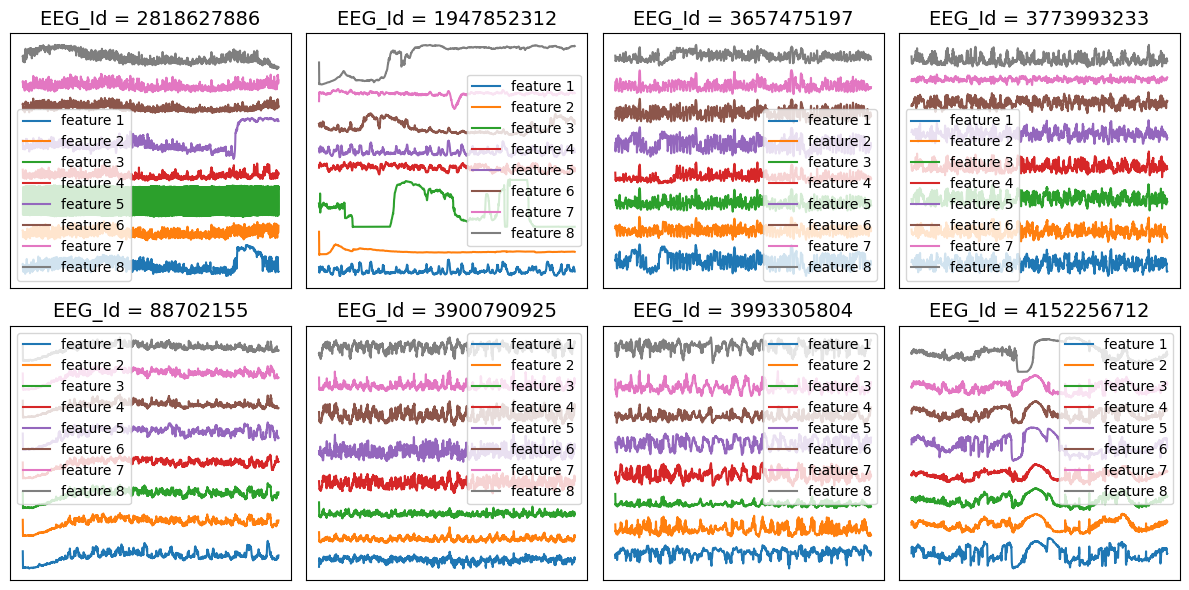

CPU times: user 5.15 s, sys: 399 ms, total: 5.55 s
Wall time: 4.77 s


In [26]:
%%time

dl_train, dl_val, ds_train, ds_val = get_fold_dls(dummy_train, dummy_valid)
show_batch(ds_val, 8, 2, 4, EEG_IDS)

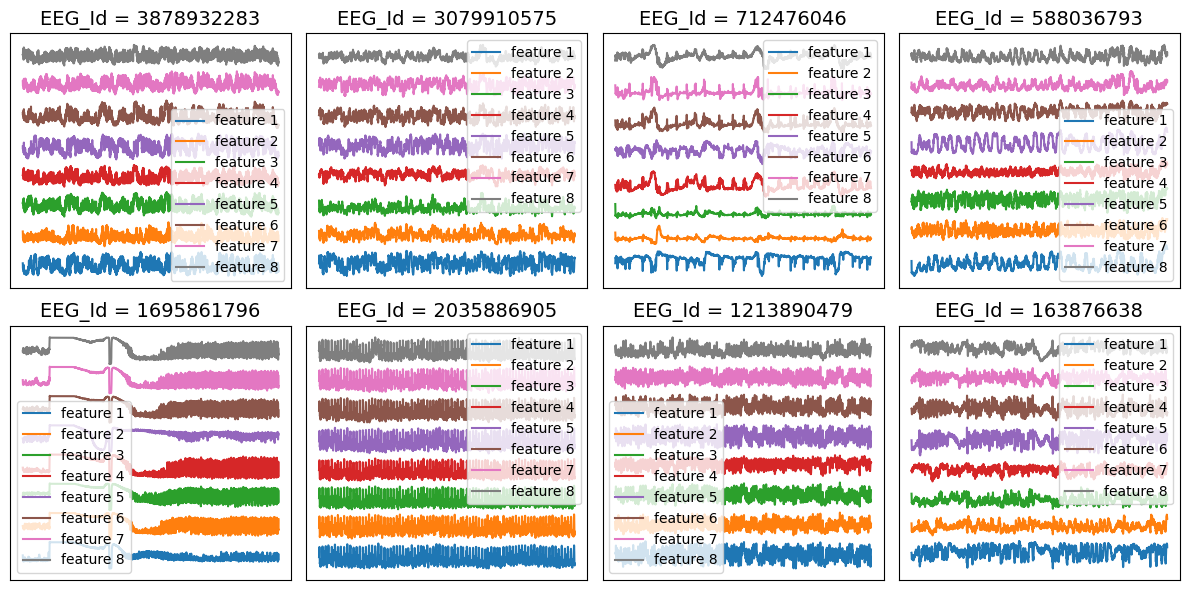

CPU times: user 5.19 s, sys: 336 ms, total: 5.53 s
Wall time: 4.86 s


In [27]:
%%time

dl_train, dl_val, ds_train, ds_val = get_fold_dls(dummy_train, dummy_valid)
show_batch(ds_train, 8, 2, 4, EEG_IDS)

## Define Optimizer

In [28]:
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR

def get_optimizer(lr, params):
    model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, params), 
            lr=lr,
            weight_decay=Config.weight_decay
        )
    interval = "epoch"
    
    lr_scheduler = CosineAnnealingWarmRestarts(
                            model_optimizer, 
                            T_0=Config.epochs, 
                            T_mult=1, 
                            eta_min=1e-6, 
                            last_epoch=-1
                        )

    return {
        "optimizer": model_optimizer, 
        "lr_scheduler": {
            "scheduler": lr_scheduler,
            "interval": interval,
            "monitor": "val_loss",
            "frequency": 1
        }
    }

## Trying out Metric Score on Dummy predictions

In [29]:
!pip install torchtoolbox

  Obtaining dependency information for torchtoolbox from https://files.pythonhosted.org/packages/e8/55/bacaf19eefb0e3f86a7cacfe597e08664dec510872f3a0f2848e61ae1dd2/torchtoolbox-0.1.8.2-py3-none-any.whl.metadata
  Obtaining dependency information for lmdb from https://files.pythonhosted.org/packages/83/67/8f32a70336d3ff1149cbd31e5a877997384f78c3940edc0abff95c8a5601/lmdb-1.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 1.6 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 5.3 MB/s eta 0:00:00a 0:00:01


In [30]:
from torchtoolbox.tools import mixup_data, mixup_criterion
import torch.nn as nn
from torch.nn.functional import cross_entropy
import torchmetrics
import timm
from pytorch_lightning.loggers import TensorBoardLogger


In [31]:
import sklearn.metrics
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')

from kaggle_kl_div import score


In [32]:
dummy = dummy_valid.copy()
dummy[TARGETS] = np.random.rand(dummy.shape[0],len(TARGETS))

dummy[TARGETS] = dummy[TARGETS].div(dummy[TARGETS].sum(axis=1), axis=0)


In [33]:
dummy_valid.head(3)

,eeg_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target,fold
7,2061593,23828,0.0,0.000000,0.0,0.0,0.0,1.000000,Other,0
9,2366870,23633,0.0,0.333333,0.0,0.0,0.0,0.666667,Other,0
15,3851658,30631,0.0,0.000000,0.0,1.0,0.0,0.000000,LRDA,0


In [34]:
dummy.head(3)

,eeg_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target,fold
7,2061593,23828,0.046705,0.323236,0.050278,0.352326,0.141965,0.085491,Other,0
9,2366870,23633,0.006407,0.272051,0.172134,0.131718,0.131567,0.286123,Other,0
15,3851658,30631,0.153166,0.079046,0.092979,0.234679,0.176263,0.263867,LRDA,0


In [35]:
score(dummy_valid[['eeg_id']+list(TARGETS)], dummy[['eeg_id']+list(TARGETS)],row_id_column_name='eeg_id')

1.706290547746621

In [36]:
# mixup_criterion(KLDivLossWithLogits)

In [37]:
class KLDivLossWithLogits(nn.KLDivLoss):

    def __init__(self):
        super().__init__(reduction="batchmean")

    def forward(self, y, t):
        y = nn.functional.log_softmax(y,  dim=1)
        loss = super().forward(y, t)

        return loss


## Define Lightning Model Class

In [38]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger


In [39]:
tensorboard_logger = TensorBoardLogger("logs/", name="EEGModel")

In [40]:
class EEGModel(pl.LightningModule):
    def __init__(self, num_classes = Config.num_classes, pretrained = Config.pretrained, fold = fold):
        super().__init__()
        self.num_classes = num_classes
        self.fold = fold
        self.backbone = EEGNet(kernels=[3,5,7,9], in_channels=Config.num_channels, fixed_kernel_size=5, num_classes=Config.num_classes)
        self.loss_function = KLDivLossWithLogits() #nn.KLDivLoss() #nn.BCEWithLogitsLoss() 
        self.validation_step_outputs = []
        self.lin = nn.Softmax(dim=1)
        self.best_score = 1000.0
    def forward(self,images):
        logits = self.backbone(images)
        # logits = self.lin(logits)
        return logits
        
    def configure_optimizers(self):
        return get_optimizer(lr=Config.LR, params=self.parameters())

    def train_with_mixup(self, X, y):
        X, y_a, y_b, lam = mixup_data(X, y, alpha=Config.mixup_alpha)
        y_pred = self(X)
        loss_mixup = mixup_criterion(KLDivLossWithLogits(), y_pred, y_a, y_b, lam)
        return loss_mixup

    def training_step(self, batch, batch_idx):
        image, target = batch        
        if Config.use_mixup:
            loss = self.train_with_mixup(image, target)
        else:
            y_pred = self(image)
            loss = self.loss_function(y_pred,target)

        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss        

    def validation_step(self, batch, batch_idx):
        image, target = batch 
        # print(target)
        y_pred = self(image)
        val_loss = self.loss_function(y_pred, target)
        self.log("val_loss", val_loss, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        self.validation_step_outputs.append({"val_loss": val_loss, "logits": y_pred, "targets": target})

        return {"val_loss": val_loss, "logits": y_pred, "targets": target}
    
    def train_dataloader(self):
        return self._train_dataloader 
    
    def validation_dataloader(self):
        return self._validation_dataloader
    
    def on_validation_epoch_end(self):
        outputs = self.validation_step_outputs
        
        # print(len(outputs))
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        output_val = nn.Softmax(dim=1)(torch.cat([x['logits'] for x in outputs],dim=0)).cpu().detach().numpy()
        target_val = torch.cat([x['targets'] for x in outputs],dim=0).cpu().detach().numpy()
        self.validation_step_outputs = []

        val_df = pd.DataFrame(target_val, columns = list(TARGETS))
        pred_df = pd.DataFrame(output_val, columns = list(TARGETS))

        val_df['id'] = [f'id_{i}' for i in range(len(val_df))] 
        pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))] 


        avg_score = score(val_df, pred_df, row_id_column_name = 'id')

        if avg_score < self.best_score:
            print(f'Fold {self.fold}: Epoch {self.current_epoch} validation loss {avg_loss}')
            print(f'Fold {self.fold}: Epoch {self.current_epoch} validation KDL score {avg_score}')
            self.best_score = avg_score
            # val_df.to_csv(f'{Config.output_dir}/val_df_f{self.fold}.csv',index=False)
            # pred_df.to_csv(f'{Config.output_dir}/pred_df_f{self.fold}.csv',index=False)
        
        return {'val_loss': avg_loss,'val_cmap':avg_score}
    


In [41]:
from tqdm import tqdm
tqdm.pandas()

In [42]:
def predict(data_loader, model):
        
    model.to('cuda')
    model.eval()    
    predictions = []
    for batch in tqdm(data_loader):

        with torch.no_grad():
            x, y = batch
            x = x.cuda()
            # inputs = {key:val.reshape(val.shape[0], -1).to(config.device) for key,val in batch.items()}
            outputs = model(x)
            outputs = nn.Softmax(dim=1)(outputs)
        predictions.extend(outputs.detach().cpu().numpy())
    predictions = np.vstack(predictions)
    return predictions

def predict2(ds_test, model):
    
    model.to('cuda')
    model.eval()    
    predictions = []
    for en in tqdm(range(len(ds_test))):
        # print(en)
        x,_ = ds_test[en]
        x = x.unsqueeze(0).cuda()
        # print(images.shape)
        with torch.no_grad():
            outputs = model(x)
            outputs = nn.Softmax(dim=1)(outputs)
            outputs = outputs.detach().cpu().numpy()

        predictions.append(outputs)
        
    return predictions

## Training Loop

In [43]:
from pytorch_lightning.loggers import WandbLogger
import gc
torch.set_float32_matmul_precision('high')
def run_training(fold_id, Config):
    print(f"Running training for fold {fold_id}...")
    logger = TensorBoardLogger("logs/", name=f"EEGModel_fold_{fold_id}")

    pred_cols = [f'pred_{t}' for t in TARGETS]
    
    df_train = train[train['fold']!=fold_id].copy()
    df_valid = train[train['fold']==fold_id].copy()

    print(len(df_train),'train length')
    print(len(df_valid),'valid length')
    
    dl_train, dl_val, ds_train, ds_val = get_fold_dls(df_train, df_valid)
    
    eeg_model = EEGModel(num_classes = Config.num_classes, pretrained = Config.pretrained, fold = fold_id)

    
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=Config.PATIENCE, verbose= True, mode="min")
    checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                          dirpath= f"{Config.output_dir}/",
                                      save_top_k=1,
                                      save_last= True,
                                      save_weights_only=False,
                                      filename= f'eegnet_best_loss_fold{fold_id}',
                                      verbose= True,
                                      mode='min')
    
    callbacks_to_use = [checkpoint_callback,early_stop_callback]


    trainer = pl.Trainer(
        devices=[0],
        
        val_check_interval=0.5,
        deterministic=True,
        max_epochs=Config.epochs,        
        logger=logger,
        callbacks=callbacks_to_use,
        precision=Config.PRECISION*2,
        accelerator="gpu" 
    )
    

    print("Running trainer.fit")
    trainer.fit(eeg_model, train_dataloaders = dl_train, val_dataloaders = dl_val)                
    # trainer.

    model = EEGModel.load_from_checkpoint(f'{Config.output_dir}/eegnet_best_loss_fold{fold_id}.ckpt',train_dataloader=None,validation_dataloader=None,config=Config)    
    preds = predict(dl_val, model)  
    print(preds.shape)
    df_valid[pred_cols] = preds
    df_valid.to_csv(f'{Config.output_dir}/pred_df_f{fold_id}.csv',index=False)
    gc.collect()
    # torch.cuda.empty_cache()
    return preds
    

In [44]:
# list(train[train['fold']==0].index)


##########################  
########################## 
##- 0.8069934784657877 -## 
##- 0.7036157331012920 -## 
##= 0.7465863334992089 -## 
##= 0.7355040572184077 -## 
##= 0.6818253941807645 =##  
########################## 
########################## 



In [45]:
# run_training()

oof_df = train.copy()
pred_cols = [f'pred_{t}' for t in TARGETS]
oof_df[pred_cols] = 0.0
for f in Config.trn_folds:
    val_idx = list(train[train['fold']==f].index)
    print(len(val_idx))
    val_preds = run_training(f, Config)    
    # val_df = pd.read_csv(f'{Config.output_dir}/val_df_f{f}.csv')
    # pred_df = pd.read_csv(f'{Config.output_dir}/pred_df_f{f}.csv')
    oof_df.loc[val_idx, pred_cols] = val_preds
    

3418
Running training for fold 0...
13671 train length
3418 valid length
Running trainer.fit


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Fold 0: Epoch 0 validation loss 1.4468040466308594
Fold 0: Epoch 0 validation KDL score 1.4468041211514069


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 0: Epoch 0 validation loss 1.290222406387329
Fold 0: Epoch 0 validation KDL score 1.2896391875573465


Validation: |          | 0/? [00:00<?, ?it/s]

Fold 0: Epoch 0 validation loss 1.0530019998550415
Fold 0: Epoch 0 validation KDL score 1.053001258478919


Validation: |          | 0/? [00:00<?, ?it/s]

Fold 0: Epoch 1 validation loss 0.9456308484077454
Fold 0: Epoch 1 validation KDL score 0.9453611365866571


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 0: Epoch 4 validation loss 0.9331175088882446
Fold 0: Epoch 4 validation KDL score 0.9327756836575937


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 0: Epoch 7 validation loss 0.9145299792289734
Fold 0: Epoch 7 validation KDL score 0.9141521884728339


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 0: Epoch 10 validation loss 0.9004635810852051
Fold 0: Epoch 10 validation KDL score 0.9002607231189887


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 0: Epoch 15 validation loss 0.8406826257705688
Fold 0: Epoch 15 validation KDL score 0.8404491858836536


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 0: Epoch 19 validation loss 0.8383582830429077
Fold 0: Epoch 19 validation KDL score 0.8380921025925518


Validation: |          | 0/? [00:00<?, ?it/s]

Fold 0: Epoch 19 validation loss 0.8138760924339294
Fold 0: Epoch 19 validation KDL score 0.8135431246930382


Validation: |          | 0/? [00:00<?, ?it/s]

Fold 0: Epoch 20 validation loss 0.8087285757064819
Fold 0: Epoch 20 validation KDL score 0.808492994335473


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 0: Epoch 21 validation loss 0.7870185375213623
Fold 0: Epoch 21 validation KDL score 0.78679973984954


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 0: Epoch 22 validation loss 0.7865439057350159
Fold 0: Epoch 22 validation KDL score 0.7862771381175578


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 107/107 [00:11<00:00,  9.26it/s]


(3418, 6)
3418
Running training for fold 1...
13671 train length
3418 valid length
Running trainer.fit


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Fold 1: Epoch 0 validation loss 1.4165675640106201
Fold 1: Epoch 0 validation KDL score 1.4165677047199539


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 1: Epoch 0 validation loss 1.1232963800430298
Fold 1: Epoch 0 validation KDL score 1.123392002609569


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 1: Epoch 1 validation loss 0.917026937007904
Fold 1: Epoch 1 validation KDL score 0.9170624328878203


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 1: Epoch 3 validation loss 0.8815611004829407
Fold 1: Epoch 3 validation KDL score 0.8818202351335196


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 1: Epoch 6 validation loss 0.8560749888420105
Fold 1: Epoch 6 validation KDL score 0.8563433046420209


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 1: Epoch 12 validation loss 0.8085867166519165
Fold 1: Epoch 12 validation KDL score 0.8087590167079021


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 1: Epoch 18 validation loss 0.8078868389129639
Fold 1: Epoch 18 validation KDL score 0.8079194710607994


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 1: Epoch 19 validation loss 0.7888291478157043
Fold 1: Epoch 19 validation KDL score 0.7889688392037987


Validation: |          | 0/? [00:00<?, ?it/s]

Fold 1: Epoch 19 validation loss 0.7663144469261169
Fold 1: Epoch 19 validation KDL score 0.766353702819757


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 1: Epoch 20 validation loss 0.7497895359992981
Fold 1: Epoch 20 validation KDL score 0.7500135227861481


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 1: Epoch 22 validation loss 0.7456585764884949
Fold 1: Epoch 22 validation KDL score 0.7458977621615289


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 1: Epoch 24 validation loss 0.7399752140045166
Fold 1: Epoch 24 validation KDL score 0.7402001128191726


Validation: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 107/107 [00:11<00:00,  9.24it/s]


(3418, 6)
3418
Running training for fold 2...
13671 train length
3418 valid length
Running trainer.fit


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Fold 2: Epoch 0 validation loss 1.6095471382141113
Fold 2: Epoch 0 validation KDL score 1.6095470514447825


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 2: Epoch 0 validation loss 1.0880520343780518
Fold 2: Epoch 0 validation KDL score 1.088353606164703


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 2: Epoch 1 validation loss 0.9230515956878662
Fold 2: Epoch 1 validation KDL score 0.9232332371997737


Validation: |          | 0/? [00:00<?, ?it/s]

Fold 2: Epoch 1 validation loss 0.906010627746582
Fold 2: Epoch 1 validation KDL score 0.906239342787972


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 2: Epoch 8 validation loss 0.8687361478805542
Fold 2: Epoch 8 validation KDL score 0.869181013009885


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 2: Epoch 9 validation loss 0.8624253869056702
Fold 2: Epoch 9 validation KDL score 0.8627366218849789


Validation: |          | 0/? [00:00<?, ?it/s]

Fold 2: Epoch 9 validation loss 0.8491107821464539
Fold 2: Epoch 9 validation KDL score 0.8494868545718389


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 2: Epoch 14 validation loss 0.8364303708076477
Fold 2: Epoch 14 validation KDL score 0.8367522484302199


Validation: |          | 0/? [00:00<?, ?it/s]

Fold 2: Epoch 14 validation loss 0.8134531378746033
Fold 2: Epoch 14 validation KDL score 0.813901819022268


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 2: Epoch 16 validation loss 0.7997989654541016
Fold 2: Epoch 16 validation KDL score 0.8002110868345185


Validation: |          | 0/? [00:00<?, ?it/s]

Fold 2: Epoch 16 validation loss 0.7986252307891846
Fold 2: Epoch 16 validation KDL score 0.7990148507790582


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 2: Epoch 19 validation loss 0.7930059432983398
Fold 2: Epoch 19 validation KDL score 0.7934813322123465


Validation: |          | 0/? [00:00<?, ?it/s]

Fold 2: Epoch 19 validation loss 0.7919098734855652
Fold 2: Epoch 19 validation KDL score 0.7923555455238576


Validation: |          | 0/? [00:00<?, ?it/s]

Fold 2: Epoch 20 validation loss 0.7700161337852478
Fold 2: Epoch 20 validation KDL score 0.7704101263757853


Validation: |          | 0/? [00:00<?, ?it/s]

Fold 2: Epoch 20 validation loss 0.7611291408538818
Fold 2: Epoch 20 validation KDL score 0.761567970160023


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 2: Epoch 22 validation loss 0.7606931328773499
Fold 2: Epoch 22 validation KDL score 0.7611265193335441


Validation: |          | 0/? [00:00<?, ?it/s]

Fold 2: Epoch 23 validation loss 0.75313401222229
Fold 2: Epoch 23 validation KDL score 0.7535928367804696


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 107/107 [00:11<00:00,  9.33it/s]


(3418, 6)
3418
Running training for fold 3...
13671 train length
3418 valid length
Running trainer.fit


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Fold 3: Epoch 0 validation loss 1.5358777046203613
Fold 3: Epoch 0 validation KDL score 1.5358776443634339


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 3: Epoch 0 validation loss 1.143662691116333
Fold 3: Epoch 0 validation KDL score 1.143533828262002


Validation: |          | 0/? [00:00<?, ?it/s]

Fold 3: Epoch 0 validation loss 1.0826648473739624
Fold 3: Epoch 0 validation KDL score 1.0826615456729158


Validation: |          | 0/? [00:00<?, ?it/s]

Fold 3: Epoch 1 validation loss 0.9320816993713379
Fold 3: Epoch 1 validation KDL score 0.9321271769614762


Validation: |          | 0/? [00:00<?, ?it/s]

Fold 3: Epoch 1 validation loss 0.9092453718185425
Fold 3: Epoch 1 validation KDL score 0.9088996339093426


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 3: Epoch 8 validation loss 0.8999607563018799
Fold 3: Epoch 8 validation KDL score 0.9000238563587627


Validation: |          | 0/? [00:00<?, ?it/s]

Fold 3: Epoch 8 validation loss 0.8829629421234131
Fold 3: Epoch 8 validation KDL score 0.8825877318122092


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 3: Epoch 9 validation loss 0.8648164868354797
Fold 3: Epoch 9 validation KDL score 0.8646742224202144


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 3: Epoch 11 validation loss 0.837160587310791
Fold 3: Epoch 11 validation KDL score 0.8372513991234387


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 3: Epoch 14 validation loss 0.8189593553543091
Fold 3: Epoch 14 validation KDL score 0.818647291638189


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 3: Epoch 16 validation loss 0.794292151927948
Fold 3: Epoch 16 validation KDL score 0.7942635438578192


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 3: Epoch 18 validation loss 0.793867290019989
Fold 3: Epoch 18 validation KDL score 0.7938462522443387


Validation: |          | 0/? [00:00<?, ?it/s]

Fold 3: Epoch 19 validation loss 0.7936990261077881
Fold 3: Epoch 19 validation KDL score 0.7936584283941327


Validation: |          | 0/? [00:00<?, ?it/s]

Fold 3: Epoch 19 validation loss 0.7796105742454529
Fold 3: Epoch 19 validation KDL score 0.7796810741295767


Validation: |          | 0/? [00:00<?, ?it/s]

Fold 3: Epoch 20 validation loss 0.775972306728363
Fold 3: Epoch 20 validation KDL score 0.775935526849333


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 3: Epoch 21 validation loss 0.771377682685852
Fold 3: Epoch 21 validation KDL score 0.7712814952692576


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 3: Epoch 22 validation loss 0.7663034796714783
Fold 3: Epoch 22 validation KDL score 0.7662494602010623


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 107/107 [00:11<00:00,  9.39it/s]


(3418, 6)
3417
Running training for fold 4...
13672 train length
3417 valid length
Running trainer.fit


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Fold 4: Epoch 0 validation loss 1.4393203258514404
Fold 4: Epoch 0 validation KDL score 1.4393202472195554


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 4: Epoch 0 validation loss 1.2230385541915894
Fold 4: Epoch 0 validation KDL score 1.2232390952520384


Validation: |          | 0/? [00:00<?, ?it/s]

Fold 4: Epoch 0 validation loss 0.9969357252120972
Fold 4: Epoch 0 validation KDL score 0.9972209730180032


Validation: |          | 0/? [00:00<?, ?it/s]

Fold 4: Epoch 1 validation loss 0.9832915663719177
Fold 4: Epoch 1 validation KDL score 0.9833076339885082


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 4: Epoch 3 validation loss 0.9485249519348145
Fold 4: Epoch 3 validation KDL score 0.9487059272768166


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 4: Epoch 4 validation loss 0.9213324189186096
Fold 4: Epoch 4 validation KDL score 0.9213560773981372


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 4: Epoch 9 validation loss 0.8906919956207275
Fold 4: Epoch 9 validation KDL score 0.89072900962389


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 4: Epoch 10 validation loss 0.8646756410598755
Fold 4: Epoch 10 validation KDL score 0.8648739162836115


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 4: Epoch 17 validation loss 0.8285316824913025
Fold 4: Epoch 17 validation KDL score 0.8287817451815358


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 4: Epoch 18 validation loss 0.8062532544136047
Fold 4: Epoch 18 validation KDL score 0.8065072891577223


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 4: Epoch 21 validation loss 0.7684279680252075
Fold 4: Epoch 21 validation KDL score 0.7686608398636368


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Fold 4: Epoch 22 validation loss 0.7669616937637329
Fold 4: Epoch 22 validation KDL score 0.7672315487885588


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 107/107 [00:11<00:00,  9.38it/s]


(3417, 6)


In [46]:
oof_df

,eeg_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target,fold,pred_seizure_vote,pred_lpd_vote,pred_gpd_vote,pred_lrda_vote,pred_grda_vote,pred_other_vote
0,568657,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other,4,0.512511,0.105734,0.097851,0.026503,0.039394,0.218007
1,582999,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD,2,0.094624,0.248884,0.041550,0.054755,0.037977,0.522210
2,642382,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,4,0.060335,0.047576,0.008367,0.082614,0.073399,0.727709
3,751790,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD,2,0.030846,0.090390,0.860099,0.000279,0.000852,0.017534
4,778705,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,2,0.260831,0.031464,0.026301,0.104291,0.101524,0.475589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17084,4293354003,16610,0.0,0.000000,0.00,0.000000,0.500000,0.500000,GRDA,1,0.037303,0.049442,0.002321,0.093880,0.111321,0.705733
17085,4293843368,15065,0.0,0.000000,0.00,0.000000,0.500000,0.500000,GRDA,3,0.245904,0.036862,0.014156,0.087689,0.283657,0.331732
17086,4294455489,56,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,1,0.102691,0.048434,0.072346,0.047883,0.089033,0.639614
17087,4294858825,4312,0.0,0.000000,0.00,0.000000,0.066667,0.933333,Other,2,0.209420,0.106795,0.040104,0.083095,0.079478,0.481108


In [47]:
oof_pred_df= oof_df[['eeg_id'] + list(['pred_'+i for i in TARGETS])]
oof_pred_df.columns = ['eeg_id'] + list(TARGETS)

oof_true_df = oof_df[oof_pred_df.columns].copy()

In [48]:
# oof_score = score(solution=oof_true_df, submission=oof_pred_df, row_id_column_name='eeg_id')
# print('OOF Score for solution =',oof_score)


In [49]:
Config.output_dir

'/kaggle/working'

In [50]:

oof_df.to_csv(f'{Config.output_dir}/oof.csv',index=False)
# pred_df[TARGETS].values.shape
# a.sum(axis=1)


In [51]:
val_idx = list(train[train['fold']==0].index)
oof_df.loc[val_idx, TARGETS]

,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
7,0.0,0.000000,0.0,0.000000,0.000000,1.000000
9,0.0,0.333333,0.0,0.000000,0.000000,0.666667
15,0.0,0.000000,0.0,1.000000,0.000000,0.000000
19,0.0,0.000000,0.0,0.000000,1.000000,0.000000
32,0.0,0.785714,0.0,0.142857,0.000000,0.071429
...,...,...,...,...,...,...
17049,0.0,0.000000,1.0,0.000000,0.000000,0.000000
17059,0.0,0.066667,0.0,0.333333,0.000000,0.600000
17068,0.0,0.000000,0.0,0.000000,0.333333,0.666667
17069,0.0,0.000000,1.0,0.000000,0.000000,0.000000


In [52]:


# F0:0.803
# F1:0.719
# F2: 0.761
# F3: 0.743
# F4: 0.717

### 0.OOF Score for solution = 0.749223413337422



# F0:0.797
# F1:0.703
# F2: 0.781
# F3: 0.696
# F4: 0.705

### 0.OOF Score for solution = 0.736


# F0:0.776
# F1:0.691
# F2: 0.759
# F3: 0.743
# F4: 0.718

### 0.OOF Score for solution = 0.7376



In [53]:
fold1 = EEGModel.load_from_checkpoint('/kaggle/working/eegnet_best_loss_fold1.ckpt')


In [54]:
fold1

EEGModel(
  (backbone): EEGNet(
    (parallel_conv): ModuleList(
      (0): Conv1d(8, 24, kernel_size=(3,), stride=(1,), bias=False)
      (1): Conv1d(8, 24, kernel_size=(5,), stride=(1,), bias=False)
      (2): Conv1d(8, 24, kernel_size=(7,), stride=(1,), bias=False)
      (3): Conv1d(8, 24, kernel_size=(9,), stride=(1,), bias=False)
    )
    (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv1): Conv1d(24, 24, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
    (block): Sequential(
      (0): ResNet_1D_Block(
        (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
        (conv1): Conv1d(24, 24, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(24, 24, kernel_size=(5,), stride=(

In [55]:
!pip install tensorboard


In [56]:
%load_ext tensorboard


In [57]:
%tensorboard --logdir /kaggle/working/logs/


In [158]:
from tensorflow.python.summary.summary_iterator import summary_iterator

def extract_tensorboard_data(logdir):
    scalar_data = {}
    
    for event in summary_iterator(logdir):
        for value in event.summary.value:
            if value.HasField('simple_value'):
                if value.tag not in scalar_data:
                    scalar_data[value.tag] = []
                scalar_data[value.tag].append(value.simple_value)
                
    return scalar_data

# logdir = '/kaggle/working/logs/EEGModel_fold_0/version_0/events.out.tfevents.1715597510.bfb8c3632961.26.0'
# data = extract_tensorboard_data(logdir)

In [159]:
fold_0 = "/kaggle/working/logs/EEGModel_fold_0/version_0/events.out.tfevents.1715600164.05bcd1e68647.26.0"
fold_1 = "/kaggle/working/logs/EEGModel_fold_1/version_0/events.out.tfevents.1715603754.05bcd1e68647.26.1"
fold_2 = "/kaggle/working/logs/EEGModel_fold_2/version_0/events.out.tfevents.1715607341.05bcd1e68647.26.2"
fold_3 = "/kaggle/working/logs/EEGModel_fold_3/version_0/events.out.tfevents.1715610929.05bcd1e68647.26.3"
fold_4 = "/kaggle/working/logs/EEGModel_fold_4/version_0/events.out.tfevents.1715614509.05bcd1e68647.26.4"

In [160]:
data_f0 = extract_tensorboard_data(fold_0)
data_f1 = extract_tensorboard_data(fold_1)
data_f2 = extract_tensorboard_data(fold_2)
data_f3 = extract_tensorboard_data(fold_3)
data_f4 = extract_tensorboard_data(fold_4)


In [161]:
data_f0.keys()

dict_keys(['val_loss', 'epoch', 'train_loss'])

In [162]:
data_f0['train_loss']

[1.0197895765304565,
 0.8636393547058105,
 0.8397489786148071,
 0.8207913637161255,
 0.8198562860488892,
 0.8073098659515381,
 0.8018089532852173,
 0.7946353554725647,
 0.7847059965133667,
 0.7776901721954346,
 0.7696647644042969,
 0.7607210874557495,
 0.7549087405204773,
 0.7514604330062866,
 0.7350949048995972,
 0.7249509692192078,
 0.7210112810134888,
 0.7119625210762024,
 0.7056902647018433,
 0.6923125386238098,
 0.6813879609107971,
 0.6754472255706787,
 0.6681600213050842,
 0.6631510853767395,
 0.6569932103157043]

In [163]:
data_f0['val_loss'][Config.epochs:]

[1.3161178827285767,
 1.00994074344635,
 1.1427072286605835,
 1.0960876941680908,
 1.0065339803695679,
 0.9338486790657043,
 0.840448796749115,
 0.9930124878883362,
 0.9175766110420227,
 0.8846352100372314,
 0.8677732944488525,
 0.8574551343917847,
 0.8816191554069519,
 0.8380922079086304,
 0.8135429620742798,
 0.8084929585456848,
 0.82245272397995,
 0.7867997884750366,
 0.8160692453384399,
 0.7893523573875427,
 0.7862771153450012,
 0.7900574803352356,
 0.7919728755950928,
 0.7876299619674683,
 0.7907419800758362]

In [164]:
loss = {'train_loss':[data_f0['train_loss']],'val_loss':[data_f0['val_loss'][Config.epochs:]]}


In [165]:
loss['train_loss'].append(data_f1['train_loss'])
loss['val_loss'].append(data_f1['val_loss'][Config.epochs:])
loss['train_loss'].append(data_f2['train_loss'])
loss['val_loss'].append(data_f2['val_loss'][Config.epochs:])
loss['train_loss'].append(data_f3['train_loss'])
loss['val_loss'].append(data_f3['val_loss'][Config.epochs:])
loss['train_loss'].append(data_f4['train_loss'])
loss['val_loss'].append(data_f4['val_loss'][Config.epochs:])

In [166]:
train_loss = loss['train_loss'] 
val_loss = loss['val_loss']

In [167]:
train_loss = np.asarray(train_loss)
train_loss = np.mean(train_loss, axis =0)

In [168]:
val_loss = np.asarray(val_loss)
val_loss = np.mean(val_loss, axis =0)

In [169]:
train_loss 

array([1.00810237, 0.85989759, 0.83753778, 0.82287558, 0.81929523,
       0.81058893, 0.80474355, 0.79531544, 0.79165226, 0.78200018,
       0.77529633, 0.7671791 , 0.76252419, 0.75453697, 0.74397355,
       0.73626006, 0.72903366, 0.71915287, 0.7129053 , 0.70275902,
       0.69438087, 0.68422222, 0.67847179, 0.67350357, 0.66774491])

In [170]:
val_loss

array([1.03967165, 1.02428408, 1.02020684, 0.92426528, 0.90208466,
       0.90240393, 0.97504205, 0.92691809, 0.8484529 , 0.85644805,
       0.85244694, 0.8188643 , 0.86801025, 0.81017193, 0.8396803 ,
       0.79928524, 0.78990867, 0.7807173 , 0.77734519, 0.77137649,
       0.77010312, 0.76992595, 0.77320228, 0.76469176, 0.77010612])

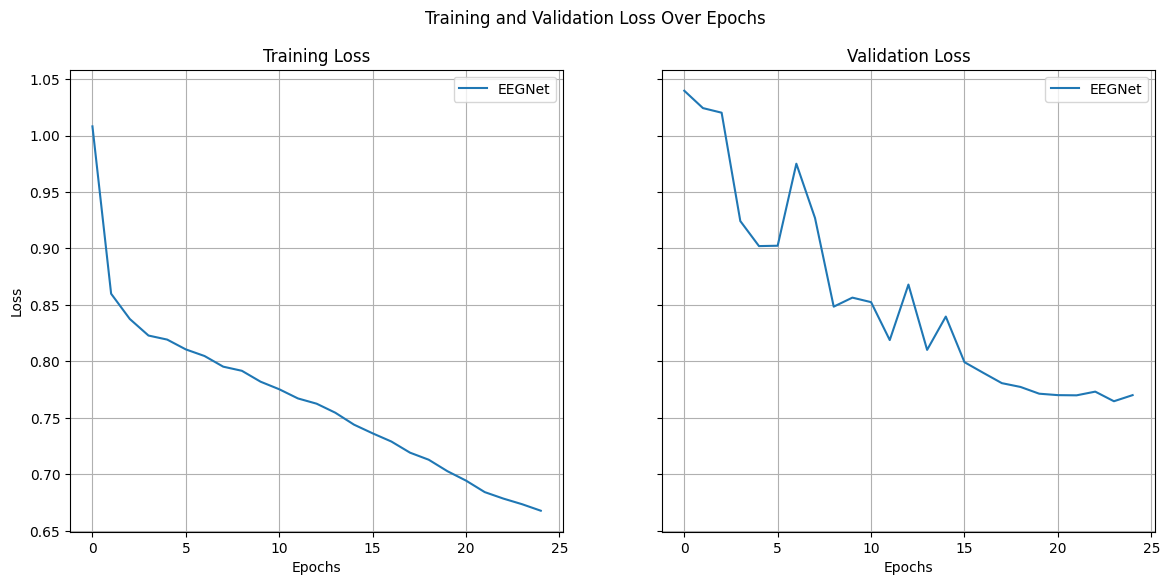

In [171]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable holding your training history data
# Example: history = model.fit(...)

# Extracting the loss and validation loss
train_loss = [1.00810237, 0.85989759, 0.83753778, 0.82287558, 0.81929523,
       0.81058893, 0.80474355, 0.79531544, 0.79165226, 0.78200018,
       0.77529633, 0.7671791 , 0.76252419, 0.75453697, 0.74397355,
       0.73626006, 0.72903366, 0.71915287, 0.7129053 , 0.70275902,
       0.69438087, 0.68422222, 0.67847179, 0.67350357, 0.66774491]
val_loss = [1.03967165, 1.02428408, 1.02020684, 0.92426528, 0.90208466,
       0.90240393, 0.97504205, 0.92691809, 0.8484529 , 0.85644805,
       0.85244694, 0.8188643 , 0.86801025, 0.81017193, 0.8396803 ,
       0.79928524, 0.78990867, 0.7807173 , 0.77734519, 0.77137649,
       0.77010312, 0.76992595, 0.77320228, 0.76469176, 0.77010612]

# Define the figure and the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot training loss
ax1.plot(train_loss, label='EEGNet')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot validation loss, if available
ax2.plot(val_loss, label='EEGNet')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epochs')
ax2.legend()
ax2.grid(True)

# Display the plots
plt.suptitle('Training and Validation Loss Over Epochs')
plt.show()